In [ ]:
import jax
import jax.numpy as jnp
import numpy as onp
import h5py
import itertools
import pylab as pl

from functools import partial
from jax.flatten_util import ravel_pytree

from jax import random
from jax.experimental import stax
from jax.experimental.stax import Tanh, Dense, BatchNorm, Conv,\
                                  ConvTranspose, Dense, Flatten, Relu, LogSoftmax, elementwise


from jax.nn.initializers import glorot_normal, normal, zeros, glorot_uniform
from jax.experimental import optimizers
from torch.utils import data

from tqdm.notebook import tqdm, trange
from scipy.integrate import solve_ivp

In [ ]:
def MLP(layer_sizes, activation_fn, last_layer_linear = True):
    """
    Vanilla MLP formutation that constructs a simple 
    feedforward neural network with the activation
    function specified.
    
    NOTE: The final layer is taken to be linear by default
    Parameters
    ----------
    layer_sizes: list
                 Specify the hidden layer and output layer
                 sizes. The size of the input layer is to be
                 specified later upon calling the initialization
                 function.
                 
    activation_fn: tuple(jax.experimental.stax.elementwise(function))
                   Specify the activation function to be applied.
                   Ensure that the function to be applied is wrapped
                   by stax.elementwise.
    
    last_layer_linear: bool
                       Flag to toggle if the last layer is to be taken
                       as a linear layer or not.
    
    """
    layers     = []
    num_layers = len(layer_sizes)
    for i in range(num_layers):
        layers.append(Dense(layer_sizes[i],
                            W_init=glorot_normal(dtype=jnp.float32),
                            b_init=normal(dtype=jnp.float32)))
        # Applying the Activation Function:
        if(i != num_layers - 1):
            layers.append(activation_fn)
        # Last Layer is Linear!
        else:
            if(last_layer_linear):
                pass
            else:
                layers.append(activation_fn)

    net_init, net_apply = stax.serial(*layers)
    return net_init, net_apply

def FF_MLP(layers, freq, activation=jnp.tanh):
    np = jnp; random = jax.random
    # Define input encoding function
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)),
                         np.cos(np.dot(x, w))])
        return out
    FF = freq * random.normal(random.PRNGKey(0), (layers[0], layers[1]//2))
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
      return params
    def apply(params, inputs):
        H = input_encoding(inputs, FF)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    return init, apply

In [ ]:
def PIDeepONet(branch_net_s0_layers, trunk_net_layers,
               activation_fn_br_s0, activation_fn_tr):
    """
    Returns the initialization and apply functions for the 
    DeepOnet with the parameters specified. Note that we 
    perform definitions assuming that a single example is
    only applied at a time.
    
    Parameters:
    -----------
    branch_net_layers: list
                       Specify the hidden layer sizes for the branch
                       net, including the output layer size.

    branch_net_layers: list
                       Specify the hidden layer sizes for the branch
                       net, including the output layer size.

    trunk_net_layers: list
                      Specify the hidden layer sizes for the trunk
                      net, including the output layer size.

    activation_fn_br: tuple(jax.experimental.stax.elementwise(function))
                      Specify the activation function to be applied to the
                      branch network. Ensure that the function to be applied 
                      is wrapped by stax.elementwise.

    activation_fn_tr: tuple(jax.experimental.stax.elementwise(function))
                      Specify the activation function to be applied to the
                      trunk network. Ensure that the function to be applied 
                      is wrapped by stax.elementwise.
    """
    # Assert that the output dims are the same:
    assert(branch_net_s0_layers[-1] == trunk_net_layers[-1])
    # Initializing branch and trunk nets:
    branch_init_s0, branch_func_s0 = MLP(branch_net_s0_layers, activation_fn_br_s0, False)
    # We have considered last layer to be nonliner for the trunk network
    # as well (as mentioned in page 4 of https://arxiv.org/pdf/1910.03193.pdf)
    # TODO: Does changing this have any implication??
    trunk_init,  trunk_func  = MLP(trunk_net_layers, activation_fn_tr, False)

    def init(rng, dim_s):
        # Parameters object:
        params = []

        # Initializing Trunk Net:
        rng, trunk_rng = random.split(rng)
        _, trunk_params = trunk_init(trunk_rng, (1,))
        params.append(trunk_params)

        # Initializing Branch Nets
        for i in range(dim_s):
            rng, branch_rng = random.split(rng)
            _, branch_params = branch_init_s0(branch_rng, 
                                              (dim_s,))
            params.append(branch_params)

            # Adding Bias:
            rng, b_rng = random.split(rng)
            b_init     = normal()
            b          = b_init(b_rng, (1,))
            params.append(b)

        return params
        
    def apply(params, s0, y):
        svector_out   = jnp.zeros(s0.size)
        trunk_params  = params[0]
        for i in range(s0.size):
            branch_params  = params[1 + 2 * i]
            bias           = params[2 + 2 * i]
            branch_out_s0  = branch_func_s0(branch_params, s0)
            trunk_out      = trunk_func(trunk_params, jnp.array([y]))
            deeponet_out   = (branch_out_s0 * trunk_out).sum() + bias[0]
            svector_out    = jax.ops.index_update(svector_out, 
                                                  jax.ops.index[i], 
                                                  deeponet_out
                                                 )
        # svector_out = jax.nn.softmax(svector_out)
        return svector_out
    
    return init, apply

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, s0, 
                 batch_size = 64, 
                 rng_key = jax.random.PRNGKey(0)
                ):
        """
        Class constructor
        """
        self.s0     = s0
        
        # Checking that the data provided are all of
        # equal sizes
        self.N          = s0.shape[0]
        self.batch_size = batch_size
        self.key        = rng_key

    def __getitem__(self, index):
        """
        Returns a single batch of data
        """
        self.key, subkey = random.split(self.key)
        inputs  = self.__data_generation(subkey)
        return inputs

    @partial(jax.jit, static_argnums=(0,))
    def __data_generation(self, key):
        """
        This is the main function where the data-generation happens
        """
        idx = random.choice(key, self.N, 
                            (self.batch_size,), 
                            replace=False)

        s0     = self.s0[idx,:]
        # Construct batch
        return s0

In [ ]:
# Define the model
class PIDeepONetModel(object):
    def __init__(self, branch_net_s0_layers, trunk_net_layers,
                 activation_fn_br_s0, activation_fn_tr,
                 dim_s, ds_dx, opt_tuple, rng = jax.random.PRNGKey(0)):    
        
        # Network initialization and evaluation functions:
        self.init, self.apply = PIDeepONet(branch_net_s0_layers, trunk_net_layers,
                                           activation_fn_br_s0, activation_fn_tr)
        
        # Now initializing the functions:
        params = self.init(rng, dim_s)
        # Storing the function that needs to be satisfied:
        self.ds_dx = ds_dx
        # Declaring index variables to pass:
        self.index_vars = jnp.arange(dim_s)
        
        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = opt_tuple
        # Initializing state of the optimizer:
        self.opt_state = self.opt_init(params)
        # Utility for saving weights and reloading assuming hyperparameters are same:
        _, self.unravel = ravel_pytree(params)
        # Logger
        self.itercount    = itertools.count()
        self.loss_log_phy = []
        self.loss_log_op  = []
        self.loss_log     = []
    
    def eval_si(self, params, s0, y, i):
        return self.apply(params, s0, y)[i]

    def eval_s(self, params, s0, y):
        return self.apply(params, s0, y)
    
    def eval_ds_dx(self, params, s0, y):
        return jax.vmap(jax.grad(self.eval_si, argnums = 2),
                        (None, None, None, 0)
                       )(params, s0, y, self.index_vars)
    
    def save_params(self, filename):
        params       = self.get_params(self.opt_state)
        fl_params, _ = ravel_pytree(params)
        
        h5f = h5py.File(filename, 'w')
        h5f.create_dataset('params', data = fl_params)
        h5f.close()
        return
    
    def load_params(self, file):
        h5f       = h5py.File(file, 'r')
        fl_params = h5f['params'][:]
        h5f.close()
        
        self.opt_state = self.opt_init(self.unravel(fl_params))
        return
        
    def eval_s_over_grid(self, s0, y_grid):
        params = self.get_params(self.opt_state)
        s_vals = jax.vmap(self.eval_s, (None, None, 0))(params, s0, y_grid)
        return s_vals
    
    # Defining the loss functions:
    def pe_loss_operator(self, params, s0):
        out = (self.eval_s(params, s0, 0) - s0)**2
        return out

    @partial(jax.jit, static_argnums=(0,))
    def loss_operator(self, params, batch):
        s0 = batch
        pe_loss = jax.vmap(self.pe_loss_operator, 
                           in_axes = (None, 0))(params, s0)
        return (pe_loss).mean()

    def pe_pt_loss_physics(self, params, s0, y):
        out = (   self.eval_ds_dx(params, s0, y)
                - self.ds_dx(y, self.eval_s(params, s0, y))
              )**2

        return out

    def pe_loss_physics(self, params, s0, y):
        return (jax.vmap(self.pe_pt_loss_physics, 
                         in_axes = (None, None, 0)
                        )(params, s0, y))

    @partial(jax.jit, static_argnums=(0,))
    def loss_physics(self, params, batch):
        s0 = batch
        pe_loss = jax.vmap(self.pe_loss_physics, 
                           in_axes=(None, 0, None)
                          )(params, s0, self.grid)
        return pe_loss.mean()

    @partial(jax.jit, static_argnums=(0,))
    def loss(self, params, batch):
        return   self.weight_physics * self.loss_physics(params, batch) \
               + self.weight_op * self.loss_operator(params, batch)

    def _testing_loss(self, s0):
        params = self.get_params(self.opt_state)
        return self.loss(params, s0)

    def _testing_loss_operator(self, s0):
        params = self.get_params(self.opt_state)
        return self.loss_operator(params, s0)

    def _testing_loss_physics(self, s0):
        params = self.get_params(self.opt_state)
        pe_loss = jax.vmap(self.pe_loss_physics, 
                    in_axes=(None, 0, None)
                  )(params, s0, self.grid)

        return pe_loss

    def _examine_gradients(self, s0, component = 'total'):
        params = self.get_params(self.opt_state)
        if(component == 'total'):
            g = jax.grad(self.loss)(params, s0)
        if(component == 'physics'):
            g = jax.grad(self.loss_physics)(params, s0)
        if(component == 'operator'):
            g = jax.grad(self.loss_operator)(params, s0)
        return g

    def _examine_params(self):
        params = self.get_params(self.opt_state)
        return params

    # Define a compiled update step
    @partial(jax.jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g      = jax.grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, grid, opt_weights, num_iterations):
        # Storing the evaluation grid:
        self.grid = grid
        # Creating the iterator object to generate batches
        data = iter(dataset)
        # Storing the optimization weights:
        self.weight_physics, self.weight_op = opt_weights
        pbar = trange(num_iterations)
        # Main training loop
        for it in pbar:
            batch          = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            params         = self.get_params(self.opt_state)
            
            # Tracking loss:
            loss_value_op  = self.loss_operator(params, batch)
            loss_value_phy = self.loss_physics(params, batch)
            loss_value     = self.loss(params, batch)
            self.loss_log_op.append(loss_value_op)
            self.loss_log_phy.append(loss_value_phy)
            self.loss_log.append(loss_value)
            pbar.set_postfix({'LossOp': loss_value_op,
                              'LossPhy': loss_value_phy,
                              'Loss': loss_value,
                             })
            
        return

In [ ]:
#======================================================================
# Below, we consider different ODE systems to simulate:
#======================================================================
# Considering a basic scalar valued function
# dim_s = 1
# def ds_dt(t, s):
#     return jnp.cos(t) * jnp.sin(s)

# --------- VECTOR VALUED FUNCTIONS --------------
# Most trivial system. Should show no evolution:
# dim_s = 2
# def ds_dt(t, c):
#     return 0 * c

#-----------------------
# Simple linear systems. 
#-----------------------
# dim_s = 2
# Shows solution
# MAYBE SOMETHING TO NOTE: Anything which grows probably won't be captured well (??)
# c(x) = alpha ([1, 2]).T exp(3t) + beta * ([-1, 2]).T exp(-t)
# def ds_dt(t, c):
#     c1, c2 = c
#     return jnp.array([c1 + c2, 4 * c1 + c2])

# Shows solution
# c(x) = alpha ([-sqrt(2), 1]).T exp(-4t) + beta * ([1, sqrt(2)]).T exp(-t)
# def ds_dt(t, c):
#     c1, c2 = c
#     return jnp.array([c1 + c2, 4 * c1 + c2])

# Shows solution
# c(x) = alpha ([sin(t), cos(t)]).T + beta * ([cos(t), -sin(t)]).T
# def ds_dt(t, c):
#     c1, c2 = c
#     return jnp.array([c2, -c1])

# Shows solution
# c(x) = (alpha ([sin(t), cos(t)]).T + beta * ([-cos(t), sin(t)]).T) exp(-t / 2)
# def ds_dt(t, c):
#     c1, c2 = c
#     return jnp.array([-c1 / 2 + c2, -c1 - c2 / 2])

#-----------------------
# Non-linear systems:
#-----------------------
# LotkaVolterra
# Definition of parameters
# A = 1.
# B = 0.1
# C = 1.5
# D = 0.75
# def ds_dt(t, c):
#     u, v = c
#     return jnp.array([ A * u - B * u * v ,
#                       -C * v + D * B * u * v ])

# Competing species:
# def ds_dt(t, c):
#     u, v = c
#     return jnp.array([u * (1 - u - v),
#                       v * (3 / 4 - v - u / 2)])

# VanderPol Oscillator:
# mu = 5.0
# def ds_dt(t, s):
#     x, y = s
#     return jnp.array([mu * (x - x**3 / 3 - y),
#                       x / mu])

#-----------------------
# Stiff ODE System:
#----------------------
# dim_s = 3
# def ds_dt(t, c):
#     """ODEs for Robertson's chemical reaction system."""
#     x, y, z = c

#     k1 = 0.04
#     k2 = 3.e7
#     k3 = 1.e4
    
#     xdot = -k1 * x + k3 * y * z
#     ydot = k1 * x - k3 * y * z - k2 * y**2
#     zdot = k2 * y**2
#     return jnp.array([xdot, ydot, zdot])


dim_s = 2
def ds_dt(t, c):
    """ODEs for Robertson's chemical reaction system."""
    x, z = c
    y    = 1 - x - z

    k1 = 0.04
    k2 = 3.e7
    k3 = 1.e4

    # k2 = 3.e2
    # k3 = 1.e2
    
    xdot = -k1 * x + k3 * y * z
    zdot = k2 * y**2
    return jnp.array([xdot, zdot])

# I'm using this function to compare against traditional numerical methods:
# Basically used to examine eigenvalues of hessian / Jacobian computations
def f(c):
    x, y, z = c

    k1 = 0.04
    k2 = 3.e7
    k3 = 1.e4
    
    xdot = -k1 * x + k3 * y * z
    ydot = k1 * x - k3 * y * z - k2 * y**2
    zdot = k2 * y**2

    return jnp.array([xdot, ydot, zdot])  

# Things to try out

- [x] Firstly, write up a method that allows you to probe into the network that you have constructed. Check for magnitudes of gradients + magnitude of the weights and biases.
    - Not absolutely certain on how I should be interpreting these.
- [x] Change the architecture such that I'm only solving 2 equations at a time since we have that the sum of terms always needs to be 1.
    - Doesn't significantly improve convergence
- [X] Introduce bias into the network such that the components must sum to 1 in the architecture. Additionally, try removing the last layer linearity to see if that will help with keeping values from blowing up.
    - Can manage to get the physics error to fall to really low value (1e-16). However, in this case, the solution ends up being a steady state solution like (0, 0, 1). Therefore, it completely violates the operator loss.
- Aaaaah, I'm an idiot!!! When we solve the Rober problem, we just want to solve for one particular initial condition that is (1, 0, 0). But that said, aren't we basically just doing a memorization of this result.
- Change the problem such that you aren't doing all times per iteration but a few particular times...
- [ ] Is it valid to use batch normalization when working with Deeponets? Also, I'm currently not normalizing the inputs to the network. Perhaps this is worth doing as well... 
- [ ] Can I examine the NTK eigenvalues over here?
- [ ] How do I choose optimal weights for different losses of the network? The terms that I'll have to take into consideration are the operator loss, physics loss. But not just that in and of itself - I'll have to consider proper weighting for the different components of the physics loss.
  - Perform some sort of variable scaling to avoid adverse effects?
- [ ] I have a certain set of differential equations that must be followed.
  - What if I augment that set to have new variables that take on nearly the same values. This maybe linked to the earlier variable scaling. Perhaps linked to preconditioning. Worth investigating into further...
- [ ] Try out implementing other optimization algorithms perhaps? What happens if I say use a BFGS solver over here? I'm not constrained by the stepsize over here anyway. [COMMENT: Won't this be useless when considering mini-batches]

In [ ]:
# dcdt = onp.zeros_like(s0)
# diag = onp.zeros_like(s0)
# for i in trange(n_train):
#     # eigvals[i] = onp.linalg.eigvals(jax.jacfwd(f)(s0[i]))
#     # dcdt[i] = f(s0[i])
#     diag[i] = onp.diag(jax.jacfwd(f)(s0[i]))

# # diag

# # pl.semilogy(abs(dcdt[:, 0]))
# # pl.semilogy(abs(dcdt[:, 1]))
# # pl.semilogy(abs(dcdt[:, 2]), '--', alpha = 0.4)

# # pl.semilogy(abs(eigvals[:, 0]))
# # pl.semilogy(abs(eigvals[:, 1]))
# # pl.semilogy(abs(eigvals[:, 2]), '--', alpha = 0.4)

# pl.semilogy(abs(diag[:, 0]))
# pl.semilogy(abs(diag[:, 1]))
# pl.semilogy(abs(diag[:, 2]), '--', alpha = 0.4)

In [ ]:
n_train  = 32
N_t      = 128
t_span   = 10**5
# s0       = onp.random.rand(n_train, 3) # TEMP CHANGE dim_s)
# s0       = s0 / s0.sum(axis = 1).reshape(-1, 1)
s0     = jnp.tile(jnp.array([1., 0.0, 0.0]), (n_train, 1))
t_eval = onp.logspace(-8, jnp.log10(t_span), N_t)
# Now converting to jnp arrays:
s0     = jnp.array(s0[:, jnp.array([0, 2])])
T      = jnp.array(t_eval)

In [ ]:
lr        = optimizers.exponential_decay(1e-3,
                                         decay_steps=1000, 
                                         decay_rate=0.9
                                        )
opt_tuple = optimizers.adam(lr)
model     = PIDeepONetModel([128, 128, 128, 128], [128, 128, 128, 128], 
                            Tanh, Tanh, 
                            dim_s, ds_dt, opt_tuple
                           )

In [ ]:
training_data = DataGenerator(s0, 32)

In [ ]:
model.train(training_data, T, (1, 1), 100)

KeyboardInterrupt: ignored

In [ ]:
g  = model._examine_gradients(s0[:64])
g1 = model._examine_gradients(s0[:64], 'physics')
g2 = model._examine_gradients(s0[:64], 'operator')

p = model._examine_params()

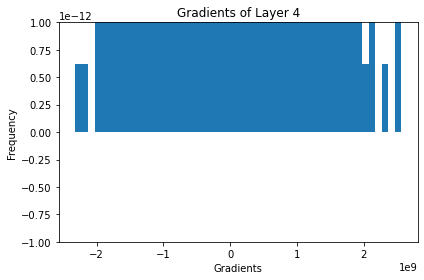

In [ ]:
# Used to choose the trunk network / branch networks
idx_network = 0
# Use 2 * i to access the gradients for that layer:
idx_layer = 6

# pl.hist(g[idx_network][idx_layer][0].ravel(), bins = 50, density = True)
pl.hist(g1[idx_network][idx_layer][0].ravel(), bins = 50, density = True)
# pl.hist(g2[idx_network][idx_layer][0].ravel(), bins = 50, density = True)
pl.title('Gradients of Layer %d'%(idx_layer // 2 + 1))
pl.xlabel('Gradients')
pl.ylabel('Frequency')
pl.tight_layout()

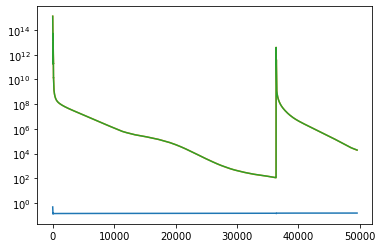

In [ ]:
pl.semilogy(model.loss_log_op)
pl.semilogy(model.loss_log_phy)
pl.semilogy(model.loss_log)

In [ ]:
# Number of times we repeat the t_span interval:
N_span = 20
s0new  = jnp.array(onp.random.rand(1, dim_s))
s0new  = jnp.array([1., 0.]) #s0new / s0new.sum()
# soln   = solve_ivp(ds_dt,
#                    (0, N_span * t_span), s0new[0], method = 'Radau',
#                    t_eval = onp.linspace(0, N_span * t_span, 
#                                          N_span * (N_t - 1) + 1
#                                         )
#                   )

In [ ]:
# Composing to capture dynamics for longer:
s_star = model.eval_s_over_grid(s0new, T)
# for i in tqdm(range(1, N_span)):
#     s_star = jnp.append(s_star, model.eval_s_over_grid(s_star[-1], T)[1:], axis = 0)

In [ ]:
print('Relative L2 Error:', jnp.linalg.norm(s_star - soln.y.T) / jnp.linalg.norm(soln.y.T))

NameError: ignored

In [ ]:
soln   = solve_ivp(ds_dt,
                   (0, t_span), s0new, method = 'Radau', atol = 1e-12,
                   t_eval = T
                  )

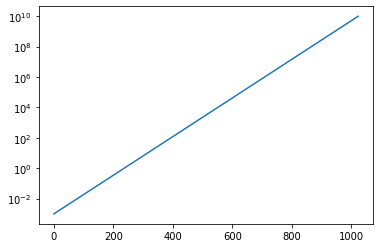

In [ ]:
pl.semilogy(T)

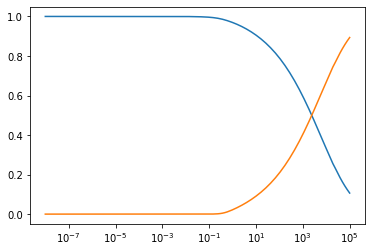

In [ ]:
pl.semilogx(soln.t, soln.y.T)
# pl.semilogx(T, s_star)

In [ ]:
to_investigate = model._testing_loss_physics(s0new)[0]

In [ ]:
g = ds_dt(soln.t, soln.y)

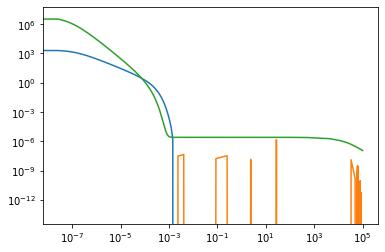

In [ ]:
pl.loglog(soln.t, g.T)

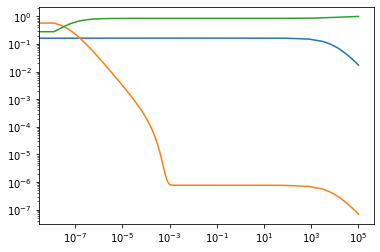

In [ ]:
pl.loglog(soln.t, soln.y.T)

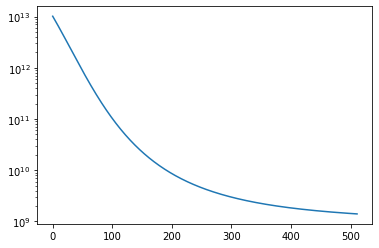

In [ ]:
pl.semilogy(to_investigate[:, 1])

In [ ]:
t = 10**(jnp.linspace(-7, 2, 64))

[[(DeviceArray([[ 6.35861402e+09,  3.26386115e+10, -7.58182144e+09,
                  3.94167214e+10,  1.02194209e+11,  2.47275971e+10,
                 -4.85325005e+09, -3.91544832e+10,  3.64752404e+10,
                 -7.75645921e+10,  1.68465910e+10, -3.23771740e+10,
                 -6.67681341e+10, -1.53003674e+10,  2.43587277e+10,
                 -1.45027994e+09, -3.99139963e+10,  1.56825037e+10,
                  3.31855012e+10, -3.45221407e+10, -1.11179932e+11,
                 -3.13592381e+10, -2.47010693e+10,  4.90257080e+10,
                 -3.71158753e+10, -2.78082227e+09,  6.17195561e+10,
                 -9.55306967e+10,  2.76651971e+10,  3.59353713e+10,
                  7.27132815e+10, -5.62442691e+10,  5.58347100e+10,
                 -1.43808741e+11,  1.41629614e+10,  7.77400320e+10,
                 -3.01288878e+10, -5.32158136e+10, -3.52417628e+10,
                 -2.83567534e+10,  7.78701292e+10,  1.50444902e+10,
                  5.38451149e+10, -8.50730650e+0

In [ ]:
t

DeviceArray([0.00000000e+00, 9.48889256e-02, 1.98781848e-01,
             3.12533021e-01, 4.37077999e-01, 5.73440790e-01,
             7.22742915e-01, 8.86212230e-01, 1.06519294e+00,
             1.26115680e+00, 1.47571564e+00, 1.71063399e+00,
             1.96784306e+00, 2.24945879e+00, 2.55779624e+00,
             2.89539194e+00, 3.26502228e+00, 3.66972494e+00,
             4.11283016e+00, 4.59798193e+00, 5.12916851e+00,
             5.71075869e+00, 6.34753752e+00, 7.04473782e+00,
             7.80809307e+00, 8.64388466e+00, 9.55898190e+00,
             1.05609112e+01, 1.16579142e+01, 1.28590107e+01,
             1.41740799e+01, 1.56139317e+01, 1.71904125e+01,
             1.89164791e+01, 2.08063316e+01, 2.28755112e+01,
             2.51410313e+01, 2.76215363e+01, 3.03374023e+01,
             3.33109741e+01, 3.65667076e+01, 4.01313705e+01,
             4.40342789e+01, 4.83075333e+01, 5.29863052e+01,
             5.81090050e+01, 6.37177887e+01, 6.98588028e+01,
             7.65825119e

In [ ]:
# Defining the GELU function:
def gelu(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))